In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from Preprocessing.preprocessing_sorted import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [2]:
#static parameters
train_batch_size = 170
val_batch_size = 170
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [3]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

[[72 76 72 ... 79 69 81]
 [76 72 67 ... 69 81 71]
 [72 67 72 ... 81 71 72]
 ...
 [71 68 64 ... 56 57 59]
 [64 66 68 ... 76 78 79]
 [81 83 81 ... 83 81 83]]
[71 72 74 ... 61 80 80]
89
50
[50 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 88 89]


In [ ]:
print(network_output.max())
print(network_output.min())

In [5]:
network_output.shape

torch.Size([8617])

In [6]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [4]:
network_input.shape

torch.Size([8617, 50, 1])

In [7]:
'''
data is highly unbalanced
# '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [8]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -117]
network_output = network_output[: -117]

print(network_input.shape)
print(network_output.shape)

torch.Size([8500, 50, 1])
torch.Size([8500])


In [9]:
#network_input[0]

In [10]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.5)
        
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, hidden,batch_size):
        
        output, hidden = self.lstm(x, hidden)        
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, self.hidden_size)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
          weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [11]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [12]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=38, bias=True)
)

In [13]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [14]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        h = tuple([each.data for each in hidden])
        

        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, h = model.forward(inputs, h,train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h = tuple([each.data for each in hidden])
        
        output, hidden = model.forward(inputs, val_h,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256_hidden_size.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.2718702 	Val Loss:3.0169748 	Train Acc: 8.32353% 	Val Acc: 11.4117651%
Validation Loss decreased from    inf to 3.016975, saving the model weights
Epoch: 1	Train Loss: 3.1063371 	Val Loss:2.9714865 	Train Acc: 8.529412% 	Val Acc: 11.4117651%
Validation Loss decreased from 3.016975 to 2.971487, saving the model weights
Epoch: 2	Train Loss: 3.0718069 	Val Loss:2.9730795 	Train Acc: 8.720588% 	Val Acc: 11.4117651%
Epoch: 3	Train Loss: 3.0509014 	Val Loss:3.0414517 	Train Acc: 9.441177% 	Val Acc: 8.5882355%
Epoch: 4	Train Loss: 3.0997689 	Val Loss:2.9621521 	Train Acc: 9.25% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.971487 to 2.962152, saving the model weights
Epoch: 5	Train Loss: 3.0059325 	Val Loss:2.8767249 	Train Acc: 9.897059% 	Val Acc: 10.9411767%
Validation Loss decreased from 2.962152 to 2.876725, saving the model weights
Epoch: 6	Train Loss: 2.9369754 	Val Loss:2.8751791 	Train Acc: 11.20588% 	Val Acc: 11.4117650%
Validation Loss decreased from 

Epoch: 55	Train Loss: 2.0863531 	Val Loss:2.0611022 	Train Acc: 30.94118% 	Val Acc: 33.0588245%
Epoch: 56	Train Loss: 2.0759363 	Val Loss:2.0195688 	Train Acc: 31.72059% 	Val Acc: 34.6470597%
Validation Loss decreased from 2.056047 to 2.019569, saving the model weights
Epoch: 57	Train Loss: 2.0597597 	Val Loss:2.0235196 	Train Acc: 33.11765% 	Val Acc: 34.4117656%
Epoch: 58	Train Loss: 2.0210873 	Val Loss:1.9767666 	Train Acc: 33.82353% 	Val Acc: 36.7058831%
Validation Loss decreased from 2.019569 to 1.976767, saving the model weights
Epoch: 59	Train Loss: 1.9786724 	Val Loss:1.9404528 	Train Acc: 36.10294% 	Val Acc: 38.0000007%
Validation Loss decreased from 1.976767 to 1.940453, saving the model weights
Epoch: 60	Train Loss: 1.9941925 	Val Loss:1.9260906 	Train Acc: 34.98529% 	Val Acc: 38.5882360%
Validation Loss decreased from 1.940453 to 1.926091, saving the model weights
Epoch: 61	Train Loss: 1.9837612 	Val Loss:1.9257414 	Train Acc: 35.72059% 	Val Acc: 38.5294124%
Validation Loss 

Epoch: 116	Train Loss: 0.7777662 	Val Loss:0.5855895 	Train Acc: 75.80882% 	Val Acc: 83.9999992%
Validation Loss decreased from 0.629698 to 0.585590, saving the model weights
Epoch: 117	Train Loss: 0.7048485 	Val Loss:0.5432622 	Train Acc: 77.95588% 	Val Acc: 85.6470597%
Validation Loss decreased from 0.585590 to 0.543262, saving the model weights
Epoch: 118	Train Loss: 0.6665400 	Val Loss:0.5229259 	Train Acc: 78.82353% 	Val Acc: 86.2352931%
Validation Loss decreased from 0.543262 to 0.522926, saving the model weights
Epoch: 119	Train Loss: 0.6451150 	Val Loss:0.4651992 	Train Acc: 79.42647% 	Val Acc: 87.1176469%
Validation Loss decreased from 0.522926 to 0.465199, saving the model weights
Epoch: 120	Train Loss: 0.6217405 	Val Loss:0.4567693 	Train Acc: 80.17647% 	Val Acc: 88.6470586%
Validation Loss decreased from 0.465199 to 0.456769, saving the model weights
Epoch: 121	Train Loss: 0.6042930 	Val Loss:0.4611342 	Train Acc: 81.27941% 	Val Acc: 87.8823525%
Epoch: 122	Train Loss: 0.600

Epoch: 185	Train Loss: 0.1939051 	Val Loss:0.1764229 	Train Acc: 93.75% 	Val Acc: 95.1764691%
Epoch: 186	Train Loss: 0.2031201 	Val Loss:0.1838949 	Train Acc: 94.20588% 	Val Acc: 94.5294106%
Epoch: 187	Train Loss: 0.2036566 	Val Loss:0.1664778 	Train Acc: 93.76471% 	Val Acc: 95.0588232%
Epoch: 188	Train Loss: 0.1855137 	Val Loss:0.1429175 	Train Acc: 94.38235% 	Val Acc: 96.0588217%
Epoch: 189	Train Loss: 0.1846832 	Val Loss:0.1111345 	Train Acc: 94.23529% 	Val Acc: 97.1764690%
Validation Loss decreased from 0.133741 to 0.111135, saving the model weights
Epoch: 190	Train Loss: 0.1782926 	Val Loss:0.1356066 	Train Acc: 94.66176% 	Val Acc: 96.0588229%
Epoch: 191	Train Loss: 0.1719776 	Val Loss:0.1890615 	Train Acc: 94.72059% 	Val Acc: 94.6470577%
Epoch: 192	Train Loss: 0.2268788 	Val Loss:0.1501766 	Train Acc: 92.95588% 	Val Acc: 96.4117640%
Epoch: 193	Train Loss: 0.2289681 	Val Loss:0.2147739 	Train Acc: 93.02941% 	Val Acc: 94.1176462%
Epoch: 194	Train Loss: 0.2617825 	Val Loss:0.2394354

Epoch: 264	Train Loss: 0.0676802 	Val Loss:0.1000220 	Train Acc: 98.17647% 	Val Acc: 97.2352934%
Epoch: 265	Train Loss: 0.0660821 	Val Loss:0.0902366 	Train Acc: 98.07353% 	Val Acc: 97.1764690%
Epoch: 266	Train Loss: 0.0718489 	Val Loss:0.0805349 	Train Acc: 97.97059% 	Val Acc: 97.3529398%
Epoch: 267	Train Loss: 0.0654994 	Val Loss:0.0828257 	Train Acc: 98.23529% 	Val Acc: 97.4705869%
Epoch: 268	Train Loss: 0.0816577 	Val Loss:0.1166646 	Train Acc: 97.55882% 	Val Acc: 96.6470569%
Epoch: 269	Train Loss: 0.1971746 	Val Loss:0.2972804 	Train Acc: 93.72059% 	Val Acc: 91.2352931%
Epoch: 270	Train Loss: 0.5047963 	Val Loss:0.5105223 	Train Acc: 84.91176% 	Val Acc: 85.6470585%
Epoch: 271	Train Loss: 0.5518170 	Val Loss:0.2970934 	Train Acc: 83.88235% 	Val Acc: 90.9411758%
Epoch: 272	Train Loss: 0.4754439 	Val Loss:0.1740756 	Train Acc: 85.22059% 	Val Acc: 94.9411756%
Epoch: 273	Train Loss: 0.3127927 	Val Loss:0.1555692 	Train Acc: 90.22059% 	Val Acc: 95.6470573%
Epoch: 274	Train Loss: 0.18744

Epoch: 347	Train Loss: 0.0532582 	Val Loss:0.0547441 	Train Acc: 98.57353% 	Val Acc: 98.1176454%
Validation Loss decreased from 0.060348 to 0.054744, saving the model weights
Epoch: 348	Train Loss: 0.0531424 	Val Loss:0.0701563 	Train Acc: 98.45588% 	Val Acc: 97.8235275%
Epoch: 349	Train Loss: 0.0504142 	Val Loss:0.0619176 	Train Acc: 98.61765% 	Val Acc: 97.8823525%
Epoch: 350	Train Loss: 0.0462040 	Val Loss:0.0648690 	Train Acc: 98.72059% 	Val Acc: 97.9999983%
Epoch: 351	Train Loss: 0.0457462 	Val Loss:0.0632131 	Train Acc: 98.75% 	Val Acc: 97.8823519%
Epoch: 352	Train Loss: 0.0441373 	Val Loss:0.0619055 	Train Acc: 98.77941% 	Val Acc: 97.9411751%
Epoch: 353	Train Loss: 0.0451012 	Val Loss:0.0697523 	Train Acc: 98.66176% 	Val Acc: 97.8823519%
Epoch: 354	Train Loss: 0.0422443 	Val Loss:0.0584874 	Train Acc: 98.89706% 	Val Acc: 97.8823513%
Epoch: 355	Train Loss: 0.0411889 	Val Loss:0.0547146 	Train Acc: 98.95588% 	Val Acc: 98.1764692%
Validation Loss decreased from 0.054744 to 0.054715,

Epoch: 430	Train Loss: 0.0720854 	Val Loss:0.0978017 	Train Acc: 97.80882% 	Val Acc: 97.1764690%
Epoch: 431	Train Loss: 0.0621757 	Val Loss:0.0808729 	Train Acc: 98.32353% 	Val Acc: 97.2941166%
Epoch: 432	Train Loss: 0.0576547 	Val Loss:0.0804682 	Train Acc: 98.45588% 	Val Acc: 97.8235286%
Epoch: 433	Train Loss: 0.0556770 	Val Loss:0.0954394 	Train Acc: 98.52941% 	Val Acc: 97.2352928%
Epoch: 434	Train Loss: 0.0514082 	Val Loss:0.0999173 	Train Acc: 98.58823% 	Val Acc: 97.1176463%
Epoch: 435	Train Loss: 0.0449707 	Val Loss:0.0994262 	Train Acc: 98.98529% 	Val Acc: 97.2352928%
Epoch: 436	Train Loss: 0.0475972 	Val Loss:0.0995978 	Train Acc: 98.83823% 	Val Acc: 97.4705863%
Epoch: 437	Train Loss: 0.0434320 	Val Loss:0.1069952 	Train Acc: 98.79412% 	Val Acc: 97.1176451%
Epoch: 438	Train Loss: 0.0411274 	Val Loss:0.1065052 	Train Acc: 99.0% 	Val Acc: 97.2941166%
Epoch: 439	Train Loss: 0.0378271 	Val Loss:0.1105581 	Train Acc: 99.04412% 	Val Acc: 97.4117637%
Epoch: 440	Train Loss: 0.0443448 	

#### Music Genaration


In [15]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256_hidden_size.pt'))

<All keys matched successfully>

In [62]:
#load population database
#testing_data = np.ones(200)*0
testing_data = list(range(50,90))
testing_data.extend(testing_data[::-1])
testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

In [64]:
#testing_data

In [65]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
        
        test_hidden = model.hidden_init(test_batch_size)
        test_output,_ = model.forward(test_slice, test_hidden, test_batch_size)
    
        top_p, top_class = test_output.topk(1,dim =1)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [66]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [67]:
#predicted_notes_lst

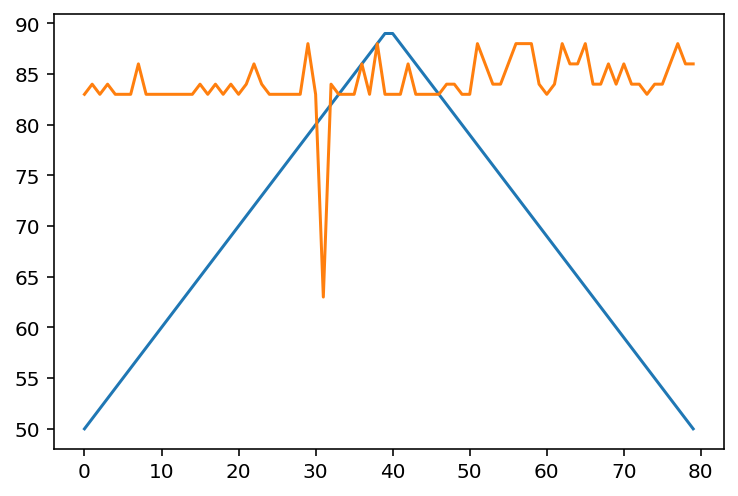

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data)
plt.plot(predicted_notes_lst)

In [45]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 5,
         74: 37,
         76: 9,
         81: 16,
         79: 21,
         69: 66,
         67: 24,
         71: 10,
         66: 1,
         62: 4,
         73: 2,
         78: 2,
         64: 2,
         83: 1})